In [1]:
import urllib3
from bs4 import BeautifulSoup
import numpy as np
import time, datetime
import matplotlib.pyplot as plt

We get the transaction data from https://arbiscan.io/txs via html extraction, since the API is rather bad.

In [2]:
# We get the first page with the most recent data
http = urllib3.PoolManager()
url = 'https://arbiscan.io/txs'
resp = http.request('GET', url)
arr = [resp.data]
# At most 4 req a second.
time.sleep(0.25)

# The amount of pages. Since backlog is around 2 weeks it's best to take at least 14
page_amt = 14
pages_per_page = 5
page_lmt = 9998 - pages_per_page
step_size = int(page_lmt/page_amt)
for i in range(1,page_amt+1):
    for j in range(pages_per_page):
        url = 'https://arbiscan.io/txs?p=' + str(step_size*i + j)
        resp = http.request('GET', url)
        arr.append(resp.data)
        time.sleep(0.25)

We parse the data into an array of transaction costs and dates.

In [3]:
def get_costs(soup):
    txCosts = soup.find_all(class_='small text-secondary')[1:]
    amt = len(txCosts)
    for i in range(amt):
        # We cut off everything until the first number
        txCosts[i] = str(txCosts[i])[35:]
        res = ''
        for char in txCosts[i]:
            if char.isnumeric() or (char == '.'):
                res += char
            # We're already inside the end span
            elif char == 's':
                break
        txCosts[i] = float(res)
    # We could also take the average around the median.
    # txCosts = np.sort(txCosts)[15:-15]
    return np.mean(txCosts)

In [4]:
def get_dates(soup):
    txDate = soup.find_all(class_='showAge')
    txDate[24] = str(txDate[24])[102:121]
    # We turn the time string into a datetime object
    pos = 0
    res = ''
    arr = np.zeros(6)
    for char in txDate[24]:
        if char.isnumeric():
            res += char
        else:
            arr[pos] = res
            res = ''
            pos += 1
    Date = datetime.datetime(int(arr[0]), int(arr[1]), int(arr[2]), int(arr[3]), int(arr[4]), int(arr[5]))
    return Date

In [5]:
# We turn the array into average dates and costs
dates = np.array([])
costs = np.array([])
for page in arr:
    soup = BeautifulSoup(page,'html.parser')
    dates = np.append(dates, get_dates(soup))
    costs = np.append(costs, get_costs(soup))

In [10]:
# We average the days together
temp_costs = np.zeros(page_amt)
temp_dates = np.array([])
for i in range(page_amt):
    idx = i*pages_per_page
    temp_costs[i] = np.mean(costs[idx:idx+pages_per_page])
    temp_dates = np.append(temp_dates, dates[idx+int(pages_per_page/2)])
costs = temp_costs
dates = temp_dates

Average transaction price in arbitrum: 


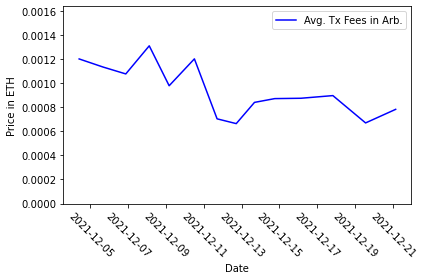

In [84]:
print("Average transaction price in arbitrum: ")
plt.ylim((0, np.max(costs)*1.25))
plt.ylabel('Price in ETH')
plt.xlabel('Date')
plt.xticks(rotation=-45)
plt.plot(dates, costs, 'b-', label="Avg. Tx Fees in Arb.")
plt.tight_layout()
plt.legend()
plt.savefig('./report/Pictures/arb_avg_eth.png')
plt.show()

In [12]:
import cryptocompare
import pandas as pd
import requests
import csv

In [13]:
prices = []
for date in dates:
    prices.append(cryptocompare.get_historical_price('ETH', 'USD', date)['ETH']['USD'])

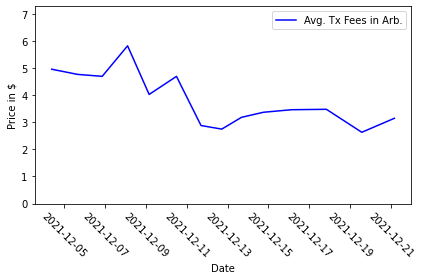

In [83]:
usd_costs = np.multiply(prices, costs)
plt.ylim((0, np.max(usd_costs)*1.25))
plt.xticks(rotation=-45)
plt.ylabel('Price in $')
plt.xlabel('Date')
plt.plot(dates, usd_costs,'b-', label="Avg. Tx Fees in Arb.")
plt.tight_layout()
plt.legend()
plt.savefig('./report/Pictures/arb_avg_usd.png')
plt.show()

In [52]:
# You must download a csv with past ethereum transactions to compare from:
# url = 'https://messari.io/asset/ethereum/historical'
csv = pd.read_csv('./eth.csv')

In [53]:
# df 'Date(UTC)', 'Average Txn Fee (USD)'
eth_dates = np.array(csv['Date'])
eth_costs = np.array(csv['Average Transaction Fees'])

size = len(dates)
eth_comp = np.zeros(size)
# We get the average prices for the given dates
for i in range(size):
    date_str = dates[i].strftime("%Y-%m-%d")
    #In case date is sooner than first value.
    eth_comp[i] = eth_costs[0]
    for j in range(len(eth_dates)):
        if date_str == eth_dates[j]:
            eth_comp[i] = eth_costs[j]

In [62]:
# Calculate small moving average to make the graph nicer
d = pd.Series(eth_comp)
avg_eth_comp = d.rolling(2).mean()
avg_eth_comp[0] = eth_comp[0]
avg_eth_comp[1] = eth_comp[1]

d = pd.Series(usd_costs)
avg_usd_comp = usd_costs

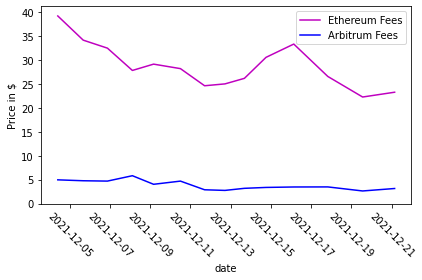

In [85]:
# Finally we plot both values in USD into a plot.
plt.ylim((0, np.max(avg_eth_comp)+2))
plt.xticks(rotation=-45)
plt.ylabel('Price in $')
plt.xlabel('date')
plt.plot(dates, avg_eth_comp,'m-', label="Ethereum Fees")
plt.plot(dates, avg_usd_comp,'b-', label="Arbitrum Fees")
plt.tight_layout()
plt.legend()
plt.savefig('./report/Pictures/arb_eth_fees.png')
plt.show()

Lastly A table to compare how much cheaper arbitrum is to ethereum

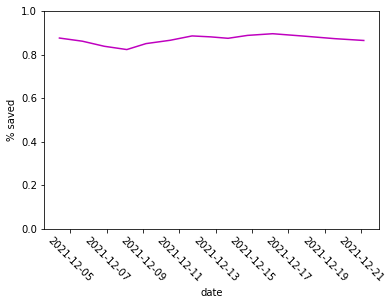

In [57]:
plt.ylim((0, 1))
plt.xticks(rotation=-45)
plt.ylabel('% saved')
plt.xlabel('date')
comp = 1-np.divide(avg_usd_comp, avg_eth_comp)
plt.plot(dates, comp,'m-')
plt.show()